In [1]:
# Install libraries
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Step 1: Install necessary libraries (run in a cell if needed)
# !pip install pymilvus sentence-transformers scikit-learn matplotlib

from pymilvus import connections, Collection, CollectionSchema, FieldSchema, DataType
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# Step 2: Connect to Milvus
connections.connect(alias="default", host="milvus-service.milvus.svc.cluster.local", port="19530")

In [4]:
# Step 3: Define collection
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=384)
]
schema = CollectionSchema(fields, description="Simple semantic vector test")
collection_name = "animal_test"
collection = Collection(name=collection_name, schema=schema)

In [5]:
# Step 4: Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
terms = ["dog", "cat", "pumpkin"]
embeddings = model.encode(terms)

# Display the first 5 rows of embedding data
for term, vector in zip(terms, embeddings):
    print(f"Embedding for '{term}' (first 5 values):\n{vector[:5]}\n")

Embedding for 'dog' (first 5 values):
[-0.05314701  0.0141944   0.00714575  0.06860869 -0.07848033]

Embedding for 'cat' (first 5 values):
[ 0.03733039  0.05116175 -0.00030608  0.06020985 -0.11749439]

Embedding for 'pumpkin' (first 5 values):
[ 0.00623482  0.02070914 -0.05396153  0.05416822 -0.01124371]



In [6]:
# Step 5: Insert into Milvus
data = [
    [0, 1, 2],  # ids
    embeddings.tolist()
]
collection.insert(data)

# Create index on the vector field
collection.create_index(
    field_name="embedding",
    index_params={
        "metric_type": "COSINE",
        "index_type": "IVF_FLAT",
        "params": {"nlist": 128}
    }
)

collection.load()

In [7]:
# Step 6: Perform search
def search(term):
    vector = model.encode([term])
    results = collection.search(vector, "embedding", param={"metric_type": "COSINE"}, limit=3)
    return results

results_dog = search("dog")

In [8]:
# Step 7: Cosine similarity for illustration
cos_sim = cosine_similarity([embeddings[0]], embeddings[1:])
print("Similarity (dog vs cat):", cos_sim[0][0])
print("Similarity (dog vs pumpkin):", cos_sim[0][1])

Similarity (dog vs cat): 0.6606375
Similarity (dog vs pumpkin): 0.37011895


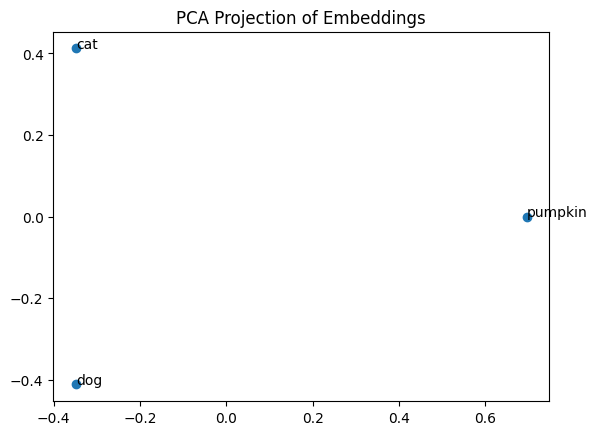

In [9]:
# Step 8: Optional visualisation
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, term in enumerate(terms):
    plt.annotate(term, (reduced[i, 0], reduced[i, 1]))
plt.title("PCA Projection of Embeddings")
plt.show()